Based on https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking/Chp_04.ipynb

Developed on colab

In [59]:
#pip install pymc3

In [60]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import scipy.stats as stats
import seaborn as sns

from scipy.interpolate import griddata


In [87]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

4.1

In [6]:
# Random walk. Here are generated two indviduals (columns) walking 4 steps each of different length with a mean length of 0.
# 2 experiments 
rng.uniform(-1, 1, size=(4, 2))

array([[ 0.70658927,  0.47483142],
       [-0.47665408,  0.81776122],
       [-0.85504834,  0.07875587],
       [ 0.38053126, -0.91729499]])

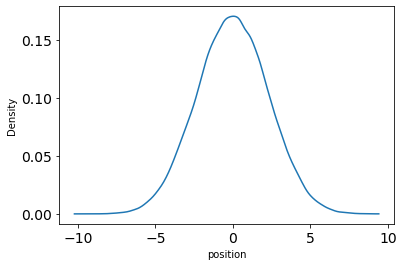

In [145]:
# Repeat for 10,000 individuals: does it look like the normal distribution
# ... this time?
pos = rng.uniform(-1, 1, size=(16, int(1e5))).sum(0)
az.plot_kde(pos)  # Kernal density estimation (need python 2.8+)
plt.xlabel("position")
plt.ylabel("Density");

Figure 4.2

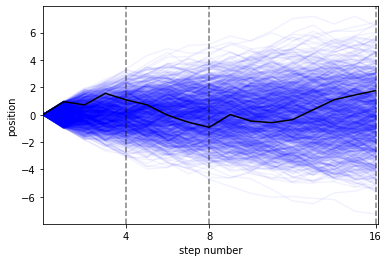

In [156]:
# Initialize a random generator.
step_rng = np.random.default_rng(1234)

steps = 16         # number of steps to take, each drawn from same distribution.
repetitions = 1000 # i.e. individuals

show_steps = [4, 8, 16]

# Set up a matrix, 17 rows (steps) for 1000 individuals (columns)
x = np.zeros([steps + 1, repetitions])

for i in range(x.shape[1]): # loop through the columns (indviduals)
    # For each, add a column of left (-1) or right (1) steps
    # These are added cumulatively.
    x[1:, i] = np.cumsum(step_rng.uniform(-1, 1, steps))

fig, ax = plt.subplots()
plt.plot(range(0, steps + 1), x[:, :],c="b" ,alpha=0.05)
plt.plot(range(0, steps + 1), x[:, 0], c="k")
for step in show_steps:
    plt.axvline(step, linestyle="--", c="k", alpha=0.5)

plt.xlabel("step number")
plt.ylabel("position")
ax.set_xticks(show_steps)
plt.xlim(0, step + 0.1)
plt.show()


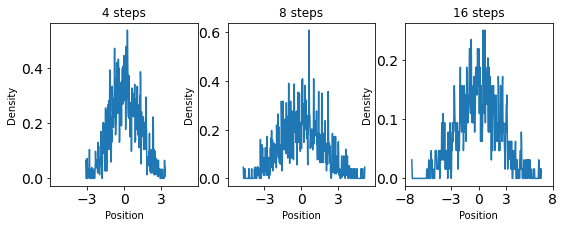

In [157]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True)

for step, ax in zip(show_steps, axs):
    az.plot_kde(x[step, :], bw=0.01, ax=ax)
    ax.set_title(f"{step} steps")
    ax.set_ylabel("Density")
    ax.set_xlabel("Position")
    ax.set_xlim(-6, 6)
    ax.set_xticks([-8, -3, 0, 3, 8])

*4.2, 4.3* Show the effect of multiplying random numbers together

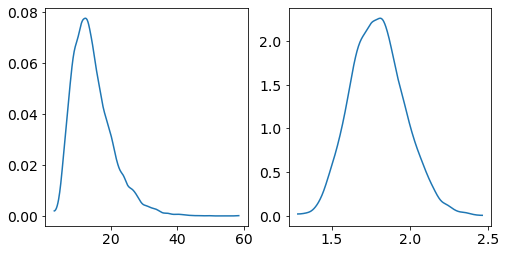

In [8]:
_, ax = plt.subplots (1, 2, figsize=(8,4) )
big= rng.uniform(1, 1.5, size=[12,10000]).prod(axis=0) 
small= rng.uniform(1, 1.1, size=[12,10000]).prod(axis=0) 

az.plot_kde ( big, ax = ax[0])
az.plot_kde ( small, ax = ax[1])


4.5 Even if you multiply large numbers together, the log will be close to normal

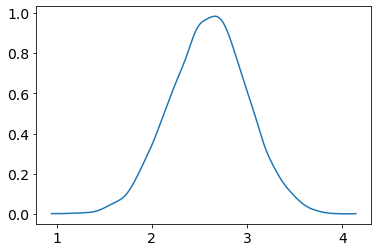

In [12]:
big_log = np.log ( rng.uniform(1, 1.5, size=[12,10000]).prod(axis=0)  ) 
az.plot_kde ( big_log)

4.6


In [41]:
w = 6; n = 9
p_grid = np.linspace ( 0, 1, 100 )
posterior = stats.binom.pmf ( k=w, n=n, p= p_grid ) * \
            stats.uniform.pdf ( p_grid, 0, 1  ) # list of ones
    
posterior = posterior / sum (posterior )
sum ( posterior)

0.9999999999999999

4.8

In [34]:
url = "https://raw.githubusercontent.com/steed360/Data-Analysis/main/b%20Statistical%20Rethinking/Data/Howell1.csv"

d = pd.read_csv(url,  sep=";", header=0)
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


4.9

In [61]:
d.height [0:10]


0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
5    163.830
6    149.225
7    168.910
8    147.955
9    165.100
Name: height, dtype: float64

4.10

In [35]:
d2 = d[d.age >= 18]

4.11

In [67]:
d2.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


Investigate possible priors (for height distribution)

4.12

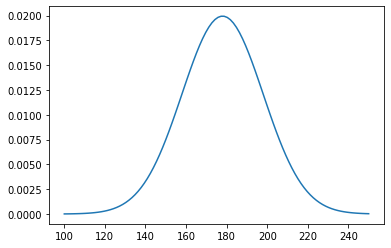

In [68]:
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20));

4.13

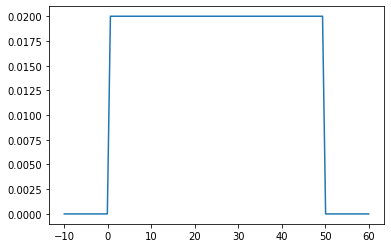

In [71]:
x = np.linspace ( -10, 60, 100)
plt.plot ( x, stats.uniform.pdf ( x, 0, 50 )  )

Predictive Simulation of Prior Information (guesses)
<BR>Needed to pick sensible priors

4.14

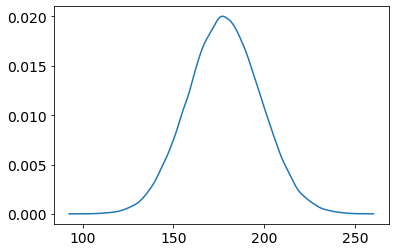

In [20]:
num_samples = int ( 1e5)
# Extract samples from the prior (hypothesized height)
# mu appears to mean the height 
sampled_mu = stats.norm.rvs (   178, 20, size = num_samples )
az.plot_kde ( sampled_mu)

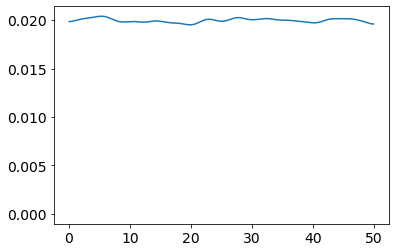

In [21]:
# Extract samples from the standard deviation sigma
sampled_sigma = stats.uniform.rvs (  0 , 50, size = num_samples )
az.plot_kde ( sampled_sigma ) 

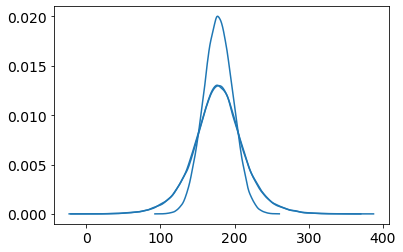

In [28]:
# Now sample from the contructed prior distribution using all of the uncertainty that 
# is in the mean distribution and the distribution of sigma
# It is a little wider than the prior height distribution with a single sigma value. 

#prior_h = stats.norm.rvs (   sampled_mu,sampled_sigma, size = num_samples )
prior_h = stats.norm.rvs(loc=sampled_mu, scale=sampled_sigma)

az.plot_kde ( prior_h)
az.plot_kde ( sampled_mu)

4.15 Using a more uninformative prior
<br> Sampled_mu is given a std of 100 instead of 20.
<br> Some of the sampled heights will come out negative.

([<matplotlib.axis.XTick at 0x7fd1bbf3f9a0>,
 <a list of 4 Text major ticklabel objects>)

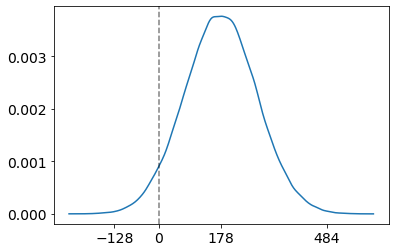

In [31]:
# sampled_mu = stats.norm.rvs (   178, 20, size = num_samples )
sampled_mu2 = stats.norm.rvs (   178, 100, size = num_samples )
prior_h2 = stats.norm.rvs(loc=sampled_mu2, scale=sampled_sigma)

az.plot_kde ( prior_h2)
plt.axvline(0 , linestyle="--", c="k", alpha=0.5)
plt.xticks ( [-128, 0, 178, 484])

In [36]:
# This is a clever way of doing a cartesian join on two lists.
# So it's a grid of mu and sigma combinations.
post = np.mgrid[150:160:0.05, 7:9:0.05].reshape(2, -1).T

# Calculate the likelihood curve from the adult height data (!)
# All of the probabilities are added up.
likelihood = [
    # We are using the log normal distribution.
    sum(stats.norm.logpdf(d2.height, loc=post[:, 0][i], scale=post[:, 1][i]))
    for i in range(len(post))
]

# Calculate the numerator.
post_prod = (
    likelihood + stats.norm.logpdf(post[:, 0], loc=178, scale=20) + stats.uniform.logpdf(post[:, 1], loc=0, scale=50)
)

post_prob = np.exp(post_prod - max(post_prod))

In [67]:
print ( post_prob.shape)
print ( post.shape ) 

(8000,)
(8000, 2)


4.17 One way to visualize the distribution is wiht a contour plot.

Text(0, 0.5, 'signma')

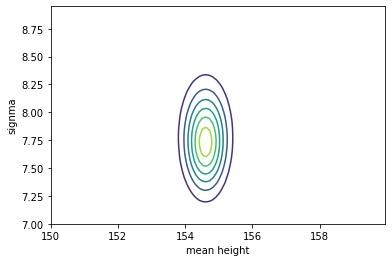

In [76]:

xi = np.linspace(post[:, 0].min(), post[:, 0].max(), 100)
yi = np.linspace(post[:, 1].min(), post[:, 1].max(), 100)
zi = griddata((post[:, 0], post[:, 1]), post_prob, (xi[None, :], yi[:, None]))

plt.contour(xi, yi, zi);

plt.xlabel ('mean height')
plt.ylabel ('signma')


4.18 Or with a heat map

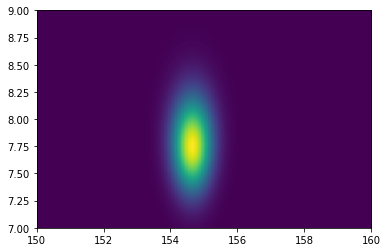

In [77]:
_, ax = plt.subplots()
ax.imshow(zi, origin="lower", extent=[150.0, 160.0, 7.0, 9.0], aspect="auto")
ax.grid(False)

Code 4.19 and 4.20 Sampling from the posterior

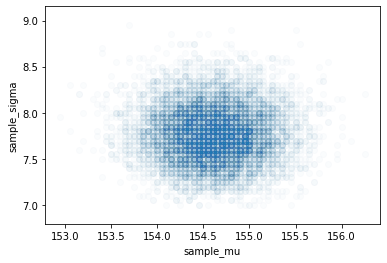

In [114]:
# Randomly generate row numbers from post_prob weighted according to the probabilities.
sample_rows = rng.choice(
    np.arange(len(post)), size=10000, replace=True, p=(post_prob / post_prob.sum())
)
# For the sampled rows grab parameter values of mu and sigma from the values grid
sample_mu = post[:, 0][sample_rows]
sample_sigma = post[:, 1][sample_rows]

# Plot points
plt.plot(sample_mu, sample_sigma, "o", alpha=0.02)
plt.axis("equal")
plt.grid(False)
plt.xlabel("sample_mu")
plt.ylabel("sample_sigma");

4.21 Using the samples from the posterior distribution, plot the mu and sigma values

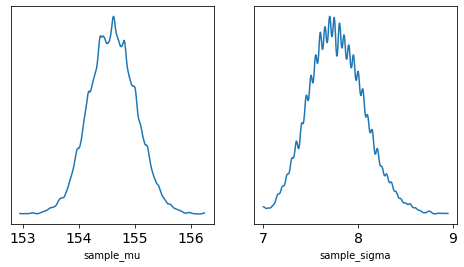

In [115]:
_, ax = plt.subplots (1, 2, figsize=(8,4) )
az.plot_kde ( sample_mu, ax=ax[0])
az.plot_kde ( sample_sigma, ax=ax[1] ) 
ax[0].set_xlabel("sample_mu")

ax[0].set_yticks([])

ax[1].set_xlabel("sample_sigma")
ax[1].set_yticks([])
ax[1].set_xticks(range (7,10))